# Week 1 B8 Progress

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Image Importing

It's easier to work with images in the form of `numpy` arrays, so I wrote a short function to convert the images into numpy arrays, and save them as such. Also have another function to load arrays from a binary file. Code is in `file_utils.py`.

## Pedestal

Since the pedestal is caused by random noise, we should be able to model it using a Gaussian of the form
$$
ae^{-\frac{(x-b)^2}{2c^2}}
$$

We therefore try and fit a Gaussian to the pedestal, and find a way to remove it.

All the code for this process can be found in `histograms.py`.

First, we need to produce histogram data from the image, which is done using `make_histogram`.

Then, we can fit the Gaussian. This can be done using the above model, and `scipy.optimize.curve_fit()`. We have to give some initial guesses to help guarantee convergence, which can be done by using the location of the max value of the histogram as an approximate peak of the pedestal (since the pedestal is much larger than the rest of the signal). This process is done in `fit_pedestal()`.


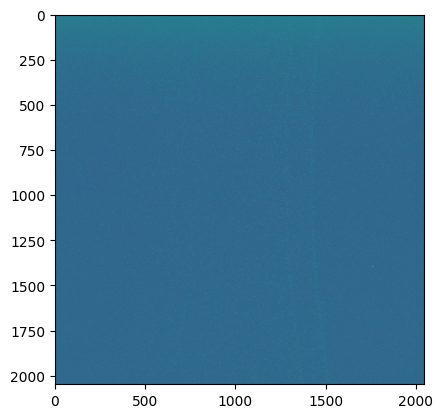

In [2]:
from file_utils import load_image

# Load an image
img = load_image("data/images/image8.npy")
plt.imshow(img, norm=LogNorm())

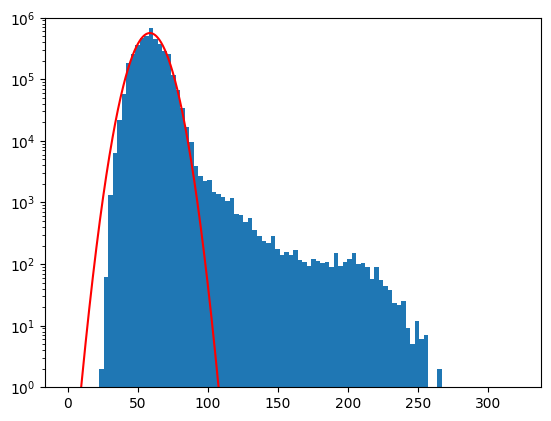

In [3]:
from histograms import fit_pedestal, make_histogram, gaussian_model


# Create and plot histogram data

bin_centres, hist_data = make_histogram(img, 100)
plt.bar(bin_centres, hist_data, width = bin_centres[1]-bin_centres[0])
plt.yscale("log")


# Fit and plot pedestal

pedestal_params, _ = fit_pedestal(bin_centres, hist_data)
xvals = np.linspace(0, bin_centres.max(), 1000)


plt.plot(xvals, gaussian_model(xvals, *pedestal_params), color="red")

plt.ylim(1,1e6)

plt.show()

Then, we need to try and remove this noise. I came up with 2 options

1. Zero all pixels that we believe to just be noise. This can be done by looking at the pedestal fit, and looking where it drops below some threshold value. All values below this point can be considered to be noise, and can be zeroed.

Benefits: Quickly cleans up noise, and completely removes it.
Drawbacks: Seems crude. Leads to absolutely no signal below a certain value, and an unnatural-looking hole in the histogram. Doesn't do anything to remove noise contribution from other "hot" pixels

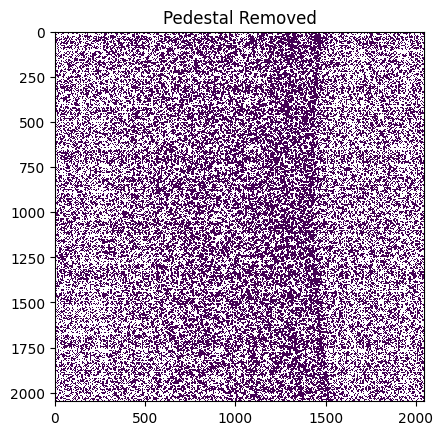

In [4]:
from histograms import remove_pedestal

pedestal_removed = remove_pedestal(img, pedestal_params, 1)

plt.imshow(pedestal_removed, norm=LogNorm())
plt.title("Pedestal Removed")
plt.show()


2. Take the intensity corresponding to the mean value of the pedestal. This will be the average amount of noise. Then, subtract this fromm every pixel in the image, to try and remove the effect of noise.

Benefits: Attempts to remove effect of noise from all hits. Still allows for possibility of signal being detected in and around the pedestal
Drawbacks: Leads to some pixels going negative, which needs to be dealt with somehow. Not as harsh a filter at getting rid of all noise.





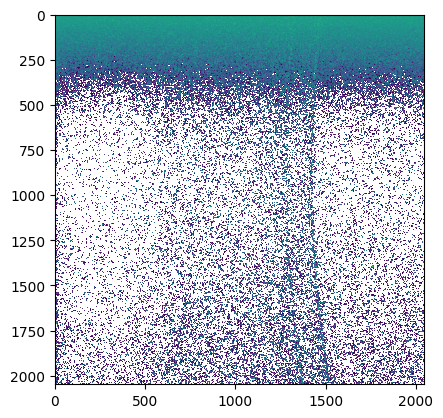

In [5]:
from histograms import subtract_pedestal

pedestal_subtracted = subtract_pedestal(img, pedestal_params)

plt.imshow(pedestal_subtracted, norm=LogNorm())

The above image clearly shows a varying bias across the image, and this will need to be corrected for at some point.

## Detecting Hits

We would like to detect all the pixels that are "hot" - ie, a photon from the experiment has lit it up, and not noise. 

The first step is getting all the hot pixels. To do this, we classify a "hot" pixel as one who's value is a certain number of standard deviations away from the overall image mean. The function `get_hot_pixels` zeroes any pixels that are not "hot"

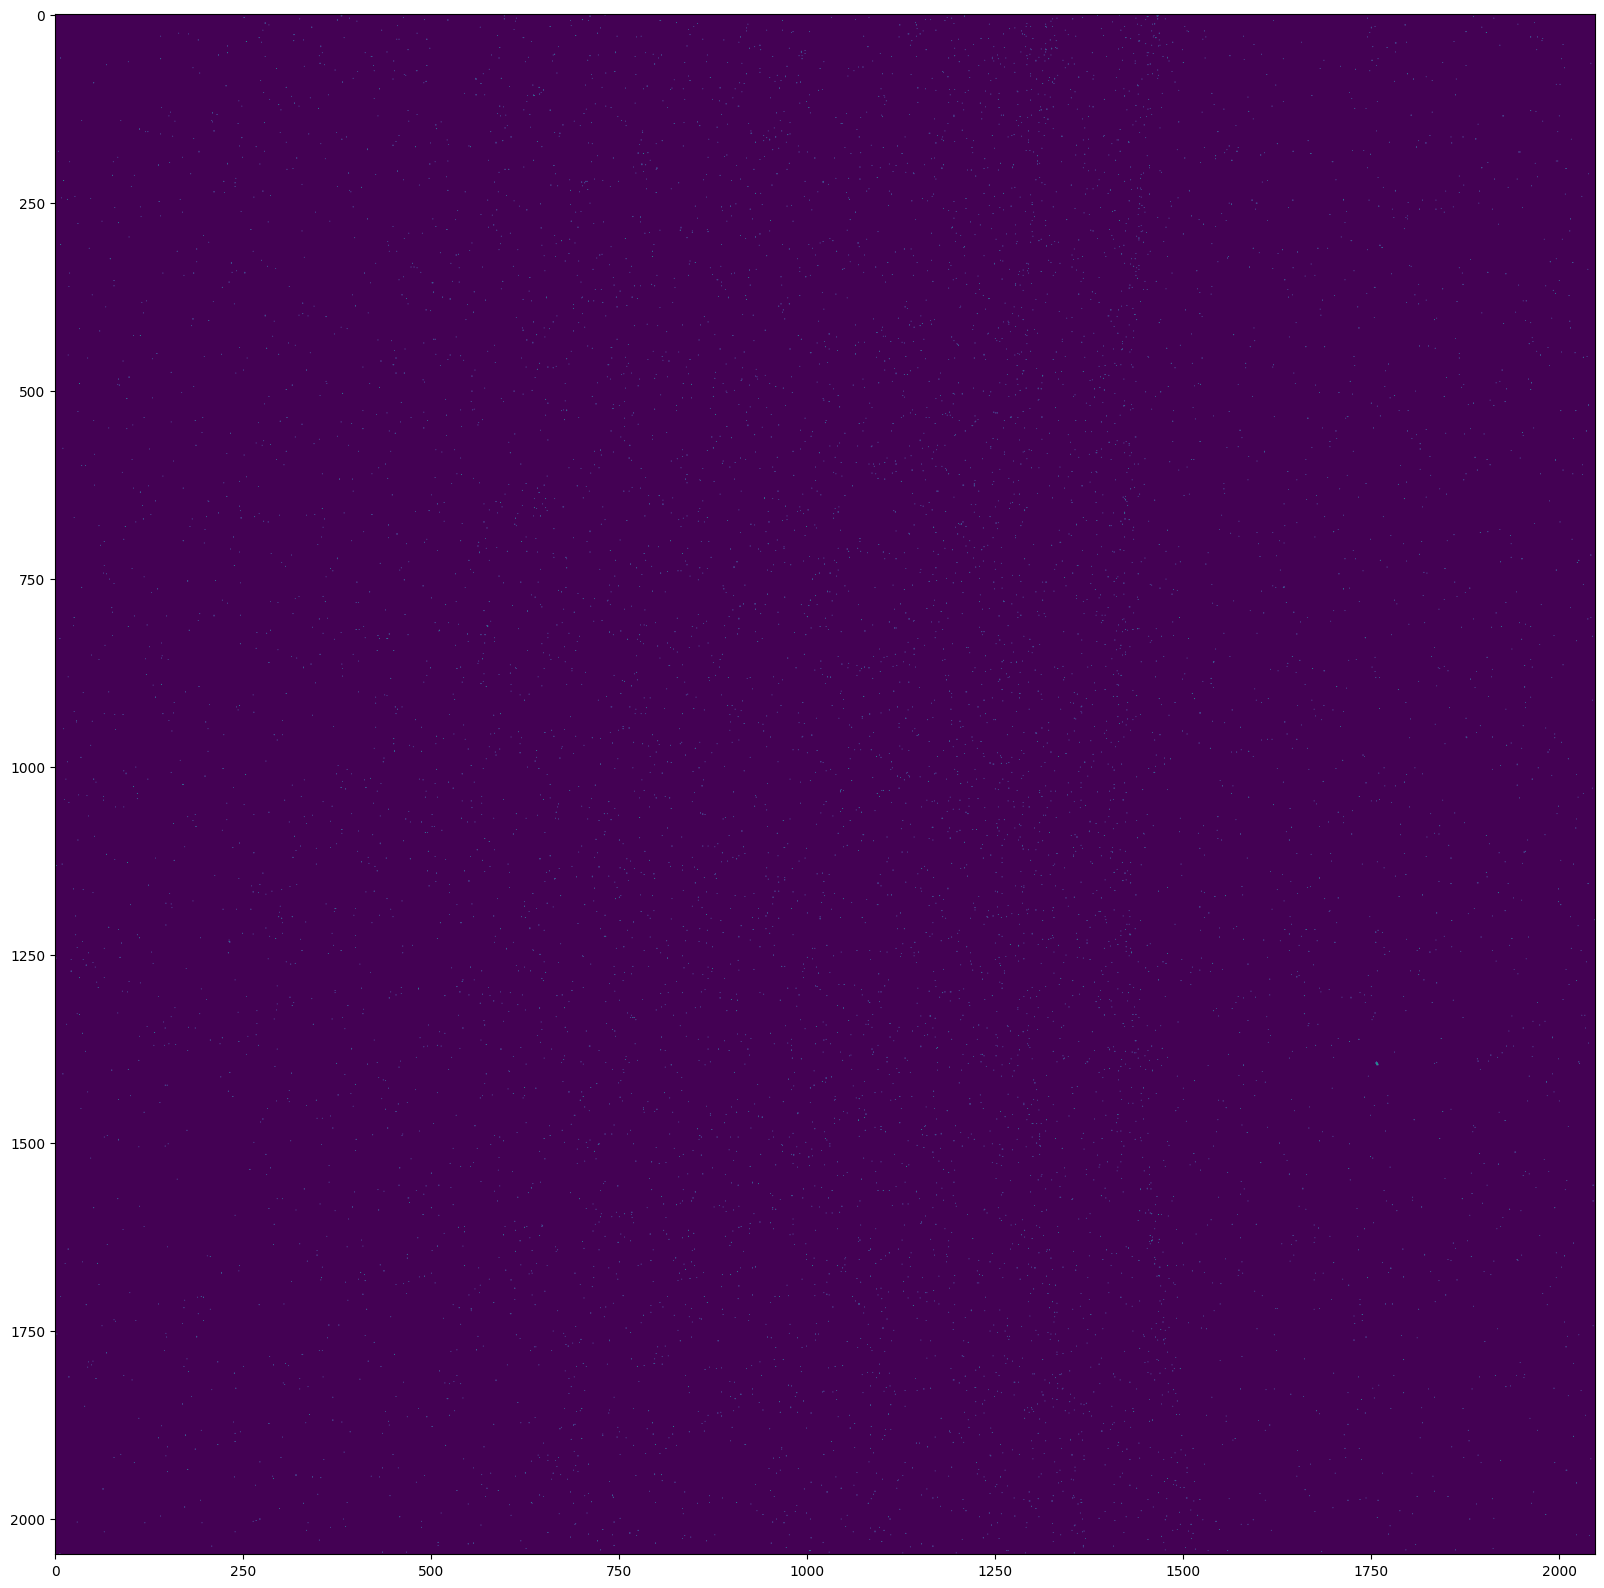

In [21]:
from hit_detection import get_hot_pixels

hot_pixels = get_hot_pixels(img, 5)
plt.figure(figsize=(20,20))
plt.imshow(hot_pixels)

plt.show()

We then want to locate hits. Some single photon hits may span more than one pixel, and double hits may span even more. To robustly find all the hits and categorize their sizes and shapes, I wrote code that:

- Iterates through the above image with non-hot pixels removed
- When a hot pixel is found, it searches out all hot pixels directly neighbouring this hot pixel using breadth-first-search.
- All these pixels are then said to conprise a "hit", and are stored as a list of locations
- These pixels are also marked "visited", and the code then keeps searching the image for the next non-visited hot pixel, and repeats the above process

In [7]:
from hit_detection import locate_hits

hits = locate_hits(img, 5)
hits

[[(0, 762)],
 [(0, 767)],
 [(0, 777)],
 [(0, 874)],
 [(1, 731)],
 [(1, 1209)],
 [(1, 1386)],
 [(1, 1415)],
 [(1, 1467)],
 [(2, 380), (2, 381)],
 [(2, 597)],
 [(2, 711), (3, 711)],
 [(2, 1465), (2, 1466), (3, 1466)],
 [(3, 1209)],
 [(3, 1452), (3, 1453)],
 [(3, 1886)],
 [(4, 251)],
 [(4, 463)],
 [(4, 1032)],
 [(4, 1082)],
 [(4, 1186)],
 [(4, 1366)],
 [(5, 391)],
 [(5, 613)],
 [(5, 1192)],
 [(5, 1332)],
 [(5, 1437)],
 [(5, 1745)],
 [(5, 1913)],
 [(6, 325)],
 [(6, 597)],
 [(6, 1326)],
 [(6, 1353)],
 [(6, 1466)],
 [(6, 1476)],
 [(7, 375), (8, 375)],
 [(7, 491)],
 [(7, 522), (8, 522)],
 [(7, 701)],
 [(7, 1064)],
 [(7, 1157)],
 [(7, 1164)],
 [(7, 1450)],
 [(8, 685)],
 [(8, 709)],
 [(8, 804), (8, 805)],
 [(8, 967)],
 [(8, 1183)],
 [(8, 1620)],
 [(9, 401)],
 [(9, 612)],
 [(9, 1324)],
 [(10, 1406)],
 [(11, 279), (12, 279)],
 [(11, 826)],
 [(11, 1144)],
 [(11, 1967)],
 [(12, 854)],
 [(12, 1195)],
 [(12, 1292)],
 [(12, 1462), (13, 1462)],
 [(13, 921)],
 [(13, 1242)],
 [(13, 1317)],
 [(13, 1439)],

In [8]:
len(hits)

8472